In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams["figure.dpi"] = 160

def remove_frame():
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

# Prepare data

In [3]:
# n_samples = 10000
# max_length = 10

# X = []
# y = []

# for i in range(n_samples):
#     x_i = np.random.rand(np.random.randint(max_length) + 1)
    
#     if np.random.rand() < 0.5 or np.all(x_i == np.sort(x_i)):
#         x_i = np.sort(x_i)
#         if np.random.rand() < 0.5:
#             x_i = x_i[::-1]
            
#         y.append(1)
#     else:
#         y.append(0)
        
#     X.append(x_i.reshape(-1,1))
        
# y = np.array(y).reshape(-1, 1)

# from sklearn.model_selection import train_test_split
# indices = np.array(range(len(X_binary)))
# train, test = train_test_split(indices)

In [35]:
n_samples = 10000
n_symbols = 5
max_length = 10

X = []
X_binary = []
y = []

for i in range(n_samples):
    x_i = np.random.randint(n_symbols, size=np.random.randint(max_length) + 1)
    len_i = len(x_i)
    
    if np.random.rand() < 0.5:
        if len_i % 2 == 0:
            x_i[:len_i//2] = x_i[len_i//2:][::-1]
        else:
            x_i[:len_i//2] = x_i[len_i//2+1:][::-1]
        y.append(1)
    else:
        if len_i % 2 == 0:
            if np.all(x_i[:len_i//2] == x_i[len_i//2:][::-1]):
                y.append(1)
            else:
                y.append(0)
        else:
            if np.all(x_i[:len_i//2] == x_i[len_i//2+1:][::-1]):
                y.append(1)
            else:
                y.append(0)

    X.append(x_i) 
            
for x_i in X:
    b = np.zeros((len(x_i), n_symbols))
    for j, x_ij in enumerate(x_i):
        b[j, x_ij] = 1
    X_binary.append(b)

In [36]:
from sklearn.model_selection import train_test_split
indices = np.array(range(len(X_binary)))
train, test = train_test_split(indices)

# RNN

In [37]:
class Elman(nn.Module):
    def __init__(self, num_features, num_hidden, num_layers=1):
        super(Elman, self).__init__()
        self.rnn = nn.RNN(num_features, num_hidden, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(num_hidden, 1)
    
    def forward(self, x):
        out, hn = self.rnn(x)
        if self.rnn.num_layers > 1:
            hn = hn[-1, :]
        out = self.fc(hn)
        return out.view(-1, 1).sigmoid()
    
class LSTM(nn.Module):
    def __init__(self, num_features, num_hidden, num_layers=1):
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(num_features, num_hidden, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(num_hidden, 1)
    
    def forward(self, x):
        out, (hn, cn) = self.rnn(x)
        out = self.fc(hn)
        return out.view(-1, 1).sigmoid()
    
class GRU(nn.Module):
    def __init__(self, num_features, num_hidden, num_layers=1):
        super(GRU, self).__init__()
        self.rnn = nn.GRU(num_features, num_hidden, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(num_hidden, 1)
    
    def forward(self, x):
        out, hn = self.rnn(x)
        out = self.fc(hn)
        return out.view(-1, 1).sigmoid()
    
class BiGRU(nn.Module):
    def __init__(self, num_features, num_hidden, num_layers=1):
        super(BiGRU, self).__init__()
        self.rnn = nn.GRU(num_features, num_hidden, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*num_hidden, 1)
        
        self.num_hidden = num_hidden
    
    def forward(self, x):
        out, hn = self.rnn(x)

        if self.rnn.num_layers > 1:
            hn = hn[-2:, :]
        
        out = self.fc(hn.view(-1, 2*self.num_hidden))
        return out.view(-1, 1).sigmoid()

In [38]:
test_curves = {}
models = {}

In [39]:
for model, name in [(Elman(n_symbols, 10), "elman"),
                    (Elman(n_symbols, 10, num_layers=2), "elman-stacked"),
                    (LSTM(n_symbols, 10), "lstm"),
                    (GRU(n_symbols, 10), "gru"),]:
                    (#BiGRU(n_symbols, 5), "bigru")]:
    
    models[name] = model
    criterion = nn.BCELoss()  
    optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)  

    num_epochs = 25 
    test_loss = []

    l = 0
    for i in test:
        x_i = torch.Tensor(X_binary[i:i+1])
        y_i = torch.Tensor(y[i:i+1])
        outputs = model(x_i)
        loss = criterion(outputs, y_i)
        l += loss       

    print('Epoch: [%d/%d], Step: Loss: %.4f' 
          % (0, num_epochs, l / len(test)))
    test_loss.append(l / len(test))

    for epoch in range(num_epochs):
        for i in train:       
            optimizer.zero_grad()

            x_i = torch.Tensor(X_binary[i:i+1])
            y_i = torch.Tensor(y[i:i+1])

            outputs = model(x_i)
            loss = criterion(outputs, y_i)
            loss.backward()

            optimizer.step()

        l = 0
        for i in test:
            x_i = torch.Tensor(X_binary[i:i+1])
            y_i = torch.Tensor(y[i:i+1])
            outputs = model(x_i)
            loss = criterion(outputs, y_i)
            l += loss       

        print('Epoch: [%d/%d], Step: Loss: %.4f' 
              % (epoch, num_epochs, l / len(test)))
        test_loss.append(l / len(test))
        
    test_curves[name] = np.array([v.detach().numpy() for v in test_loss])

Epoch: [0/25], Step: Loss: 0.6995
Epoch: [0/25], Step: Loss: 0.6672
Epoch: [1/25], Step: Loss: 0.6488
Epoch: [2/25], Step: Loss: 0.6259
Epoch: [3/25], Step: Loss: 0.5766
Epoch: [4/25], Step: Loss: 0.5387
Epoch: [5/25], Step: Loss: 0.5058
Epoch: [6/25], Step: Loss: 0.4785
Epoch: [7/25], Step: Loss: 0.4487
Epoch: [8/25], Step: Loss: 0.4217
Epoch: [9/25], Step: Loss: 0.3954
Epoch: [10/25], Step: Loss: 0.3741
Epoch: [11/25], Step: Loss: 0.3587
Epoch: [12/25], Step: Loss: 0.3481
Epoch: [13/25], Step: Loss: 0.3357
Epoch: [14/25], Step: Loss: 0.3257
Epoch: [15/25], Step: Loss: 0.3181
Epoch: [16/25], Step: Loss: 0.3115
Epoch: [17/25], Step: Loss: 0.3065
Epoch: [18/25], Step: Loss: 0.3028
Epoch: [19/25], Step: Loss: 0.2999
Epoch: [20/25], Step: Loss: 0.2973
Epoch: [21/25], Step: Loss: 0.2953
Epoch: [22/25], Step: Loss: 0.2930
Epoch: [23/25], Step: Loss: 0.2908
Epoch: [24/25], Step: Loss: 0.2887


In [56]:
test_curves

{'elman': array([0.6977668 , 0.6323324 , 0.62450373, 0.62146044, 0.57789624,
        0.5349363 , 0.4990144 , 0.48130894, 0.46617988, 0.45721802,
        0.45052823, 0.44516122, 0.4414962 , 0.4379384 , 0.4321983 ,
        0.42754042, 0.4330435 , 0.4308325 , 0.42581293, 0.41797188,
        0.41178882, 0.40919796, 0.40603667, 0.40201536, 0.39762527,
        0.39843547], dtype=float32),
 'elman-stacked': array([0.6870105 , 0.6275273 , 0.6225325 , 0.60538054, 0.5544928 ,
        0.5078323 , 0.49336988, 0.47463822, 0.4471512 , 0.43431422,
        0.4303494 , 0.43525845, 0.3825954 , 0.3713335 , 0.3712768 ,
        0.36546677, 0.41314447, 0.36470494, 0.36591393, 0.38894305,
        0.38513866, 0.37507415, 0.3854914 , 0.36508697, 0.37022692,
        0.37122142], dtype=float32),
 'lstm': array([0.68603784, 0.6280198 , 0.6101758 , 0.59064204, 0.54072195,
        0.47209877, 0.4428825 , 0.3971521 , 0.33493873, 0.29846343,
        0.27864918, 0.26603928, 0.25537416, 0.24558868, 0.235362  ,
        

# Plots

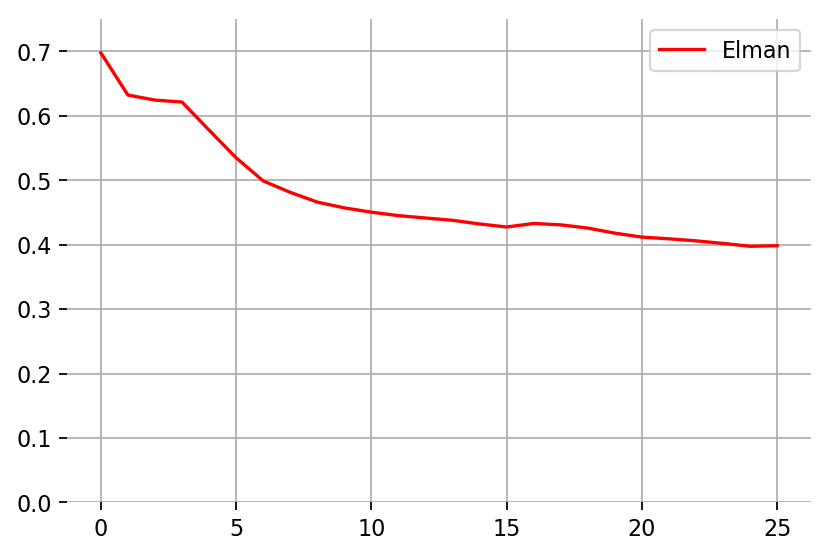

In [60]:
plt.plot(range(num_epochs+1), test_curves["elman"], c="r", label="Elman")
#plt.plot(range(num_epochs+1), test_curves["elman-stacked"], "r--", label="Elman 2-layer")
#plt.plot(range(num_epochs+1), test_curves["lstm"], c="b", label="LSTM")
#plt.plot(range(num_epochs+1), test_curves["gru"], c="g", label="GRU")
plt.ylim(0,0.75)
plt.grid()
plt.legend()
remove_frame()
plt.savefig("palindrome-1.png")
plt.show()

In [71]:
X_test = []
y_test = []

for i in range(25000):
    x_i = np.random.randint(n_symbols, size=np.random.randint(2*max_length) + 1)
    len_i = len(x_i)
    
    if np.random.rand() < 0.5:
        if len_i % 2 == 0:
            x_i[:len_i//2] = x_i[len_i//2:][::-1]
        else:
            x_i[:len_i//2] = x_i[len_i//2+1:][::-1]
        y_test.append(1)
    else:
        if len_i % 2 == 0:
            if np.all(x_i[:len_i//2] == x_i[len_i//2:][::-1]):
                y_test.append(1)
            else:
                y_test.append(0)
        else:
            if np.all(x_i[:len_i//2] == x_i[len_i//2+1:][::-1]):
                y_test.append(1)
            else:
                y_test.append(0)

    X_test.append(x_i) 

In [72]:
X_binary_test = []

for x_i in X_test:
    b = np.zeros((len(x_i), n_symbols))
    for j, x_ij in enumerate(x_i):
        b[j, x_ij] = 1
    X_binary_test.append(b)

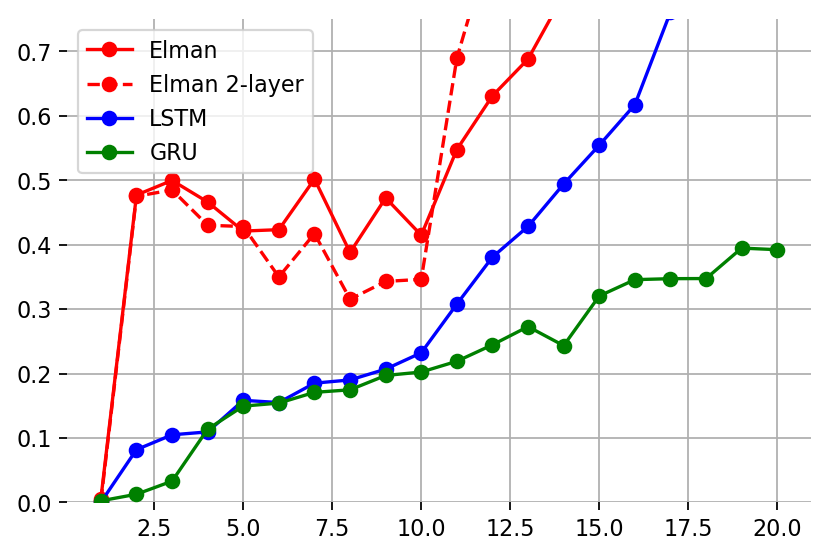

In [77]:
model = models["elman"]
l = np.zeros(2*max_length)
counters = np.zeros(2*max_length)

for i in range(len(X_test)):
    x_i = torch.Tensor(X_binary_test[i:i+1])
    y_i = torch.Tensor(y_test[i:i+1])
    outputs = model(x_i)
    loss = criterion(outputs, y_i)
    l[len(x_i[0])-1] += loss   
    counters[len(x_i[0])-1] += 1
    
plt.plot(range(1,2*max_length+1),l/counters, color="r", marker="o", label="Elman")

model = models["elman-stacked"]
l = np.zeros(2*max_length)
counters = np.zeros(2*max_length)

for i in range(len(X_test)):
    x_i = torch.Tensor(X_binary_test[i:i+1])
    y_i = torch.Tensor(y_test[i:i+1])
    outputs = model(x_i)
    loss = criterion(outputs, y_i)
    l[len(x_i[0])-1] += loss   
    counters[len(x_i[0])-1] += 1
    
plt.plot(range(1,2*max_length+1),l/counters, "r--", marker="o", label="Elman 2-layer")

model = models["lstm"]
l = np.zeros(2*max_length)
counters = np.zeros(2*max_length)

for i in range(len(X_test)):
    x_i = torch.Tensor(X_binary_test[i:i+1])
    y_i = torch.Tensor(y_test[i:i+1])
    outputs = model(x_i)
    loss = criterion(outputs, y_i)
    l[len(x_i[0])-1] += loss   
    counters[len(x_i[0])-1] += 1
    
plt.plot(range(1,2*max_length+1),l/counters, color="b", marker="o", label="LSTM")

model = models["gru"]
l = np.zeros(2*max_length)
counters = np.zeros(2*max_length)

for i in range(len(X_test)):
    x_i = torch.Tensor(X_binary_test[i:i+1])
    y_i = torch.Tensor(y_test[i:i+1])
    outputs = model(x_i)
    loss = criterion(outputs, y_i)
    l[len(x_i[0])-1] += loss   
    counters[len(x_i[0])-1] += 1
    
plt.plot(range(1,2*max_length+1),l/counters, color="g", marker="o", label="GRU")

plt.legend()
plt.ylim(0,0.75)
plt.grid()
remove_frame()
plt.savefig("length-4.png")
plt.show()